
# MVP - Previsão de Churn de Clientes

Este notebook implementa modelos de classificação para prever **churn** de clientes usando o dataset Telco Customer Churn.

Dataset: [Telco Customer Churn](https://raw.githubusercontent.com/thiagocflores/MVP_Machine_Learning/main/WA_Fn-UseC_-Telco-Customer-Churn.csv)


#Importação de bibliotecas

Nesta etapa, importamos as bibliotecas necessárias para manipulação de dados, visualização e modelagem.  

In [39]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Carregamento do dataset

O dataset está armazenado no GitHub e será carregado diretamente via URL RAW.

In [40]:

url = "https://raw.githubusercontent.com/thiagocflores/MVP_Machine_Learning/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(url)
print("Dimensões:", df.shape)
df.head()


Dimensões: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Pré-processamento

- Removemos colunas irrelevantes (ID).  
- Convertemos `TotalCharges` para numérico e tratamos valores ausentes.  
- Transformamos a variável alvo (`Churn`) em binária.  
- Aplicamos codificação em variáveis categóricas.  
- Escalonamos os atributos.  
- Dividimos em treino e teste (80/20).

In [41]:

# Remover ID irrelevante
df = df.drop("customerID", axis=1)

# Corrigir TotalCharges (valores vazios)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Target: churn -> 1/0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Codificar variáveis categóricas
cat_cols = df.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Features e target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


# Modelagem  

Treinaremos três modelos de classificação:  

- **Regressão Logística**  
- **Random Forest** (com busca de hiperparâmetros simples)  
- **XGBoost** (com busca de hiperparâmetros simples)  

# Modelo 1: Regressão Logística

In [42]:

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8402387041773232


# Modelo 2: Random Forest com GridSearch simples

In [43]:

params_rf = {"n_estimators": [100, 200], "max_depth": [5, 10, None]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), params_rf, cv=3, scoring="roc_auc", n_jobs=-1)
rf_model.fit(X_train, y_train)

best_rf = rf_model.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:,1]

print("=== Random Forest ===")
print("Melhores parâmetros:", rf_model.best_params_)
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest ===
Melhores parâmetros: {'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.69      0.43      0.53       374

    accuracy                           0.80      1409
   macro avg       0.76      0.68      0.70      1409
weighted avg       0.79      0.80      0.78      1409

ROC AUC: 0.841716396703609


# Modelo 3: XGBoost com GridSearch simples

In [44]:

params_xgb = {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.1, 0.2]}
xgb_model = GridSearchCV(XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
                         params_xgb, cv=3, scoring="roc_auc", n_jobs=-1)
xgb_model.fit(X_train, y_train)

best_xgb = xgb_model.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:,1]

print("=== XGBoost ===")
print("Melhores parâmetros:", xgb_model.best_params_)
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))


=== XGBoost ===
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.8439393939393939


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:27:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Comparação de Modelos via Curva ROC

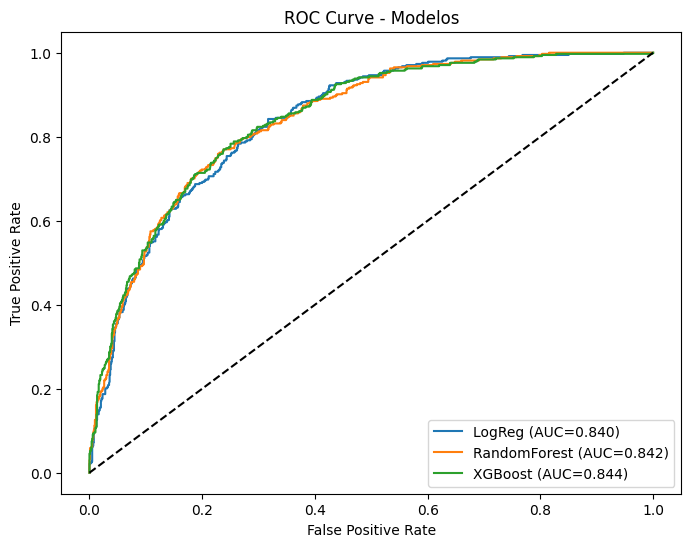

In [45]:

plt.figure(figsize=(8,6))
for model_name, y_prob in [("LogReg", y_prob_log), ("RandomForest", y_prob_rf), ("XGBoost", y_prob_xgb)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Modelos")
plt.legend()
plt.show()


# Importância das variáveis (RF e XGB)

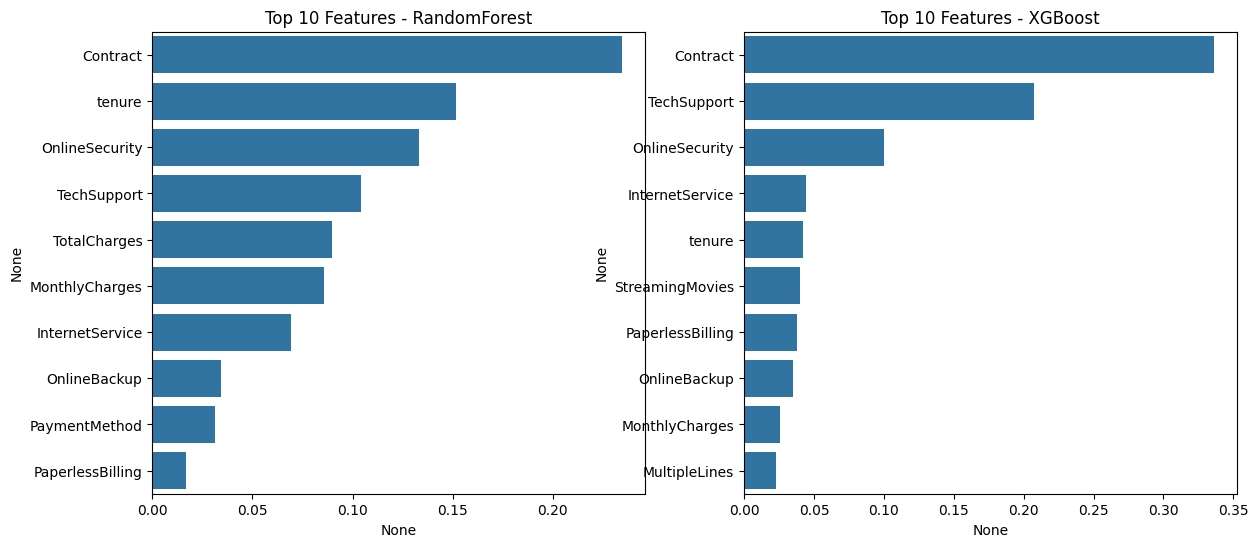

In [46]:

importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
importances_xgb = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(x=importances_rf, y=importances_rf.index, ax=axes[0])
axes[0].set_title("Top 10 Features - RandomForest")
sns.barplot(x=importances_xgb, y=importances_xgb.index, ax=axes[1])
axes[1].set_title("Top 10 Features - XGBoost")
plt.show()


# Exportação de Métricas em CSV  

Aqui consolidamos as métricas de cada modelo em um único DataFrame e exportamos para CSV.  

In [47]:
results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1": f1_score(y_test, y_pred_log),
    "ROC_AUC": roc_auc_score(y_test, y_prob_log)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_prob_rf)
})

# XGBoost
results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "ROC_AUC": roc_auc_score(y_test, y_prob_xgb)
})

results_df = pd.DataFrame(results)
results_df.to_csv("metrics_results.csv", index=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.799148,0.642633,0.548128,0.591631,0.840239
1,Random Forest,0.798439,0.692308,0.433155,0.532895,0.841716
2,XGBoost,0.805536,0.668919,0.529412,0.591045,0.843939



# Conclusões


- Todos os modelos atingiram desempenho similar em termos de AUC (≈0.84).  
- Apesar de **Random Forest** apresentar maior **precision**, ele perde em **recall**.  
- O **XGBoost** se destacou como o modelo mais **equilibrado** entre as métricas.    
- Features como `tenure`, `MonthlyCharges` e `Contract` aparecem como fortes preditores.  
- Os resultados sugerem que clientes com planos mensais e cobranças altas têm maior risco de churn, sendo foco de estratégias de retenção.  